In [49]:
#QUESTION 1

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [50]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose(
    [transforms.Resize(32),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    ,
    'test': transforms.Compose(
    [transforms.Resize(32),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
}


In [51]:
# Load the Data

# Set train and valid directory paths

# dataset = '/content/drive/My Drive/01. TEACHING/MACHINE_VISION/code/fruit_dataset'
dataset = '/content/drive/MyDrive/kneeXray'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 60

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

5


In [52]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [53]:
train_data_size, test_data_size

(5778, 826)

In [54]:
input_size = (3,32,32)

In [55]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

5778
826


In [33]:
model_ft = models.resnet18(pretrained=True)
#num_ftrs = model_ft.fc.in_features

#model_ft.fc = nn.Linear(num_ftrs, 5)

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [36]:
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.4903, Accuracy: 34.8390%, 
		Validation : Loss : 1.7961, Accuracy: 33.7772%, Time: 2734.1075s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.4439, Accuracy: 37.4005%, 
		Validation : Loss : 1.7094, Accuracy: 34.5036%, Time: 213.2399s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.4155, Accuracy: 38.4735%, 
		Validation : Loss : 1.6388, Accuracy: 34.5036%, Time: 212.8621s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.4047, Accuracy: 38.1793%, 
		Validation : Loss : 1.6163, Accuracy: 38.8620%, Time: 211.1773s
Epoch: 5/10
Epoch : 004, Training: Loss: 1.3848, Accuracy: 40.0312%, 
		Validation : Loss : 1.5900, Accuracy: 34.6247%, Time: 217.7895s
Epoch: 6/10
Epoch : 005, Training: Loss: 1.3803, Accuracy: 39.6158%, 
		Validation : Loss : 1.5380, Accuracy: 34.5036%, Time: 218.8620s
Epoch: 7/10
Epoch : 006, Training: Loss: 1.3528, Accuracy: 40.3946%, 
		Validation : Loss : 1.5204, Accuracy: 38.3777%, Time: 217.1701s
Epoch: 8/10
Epoch : 007, Training: Loss: 1.3543

In [12]:
#QUESTION 2
"""




"""
import torchvision
import torchvision.transforms as transforms

image_transforms2 = {
    'train': transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load the Data

# Set train and valid directory paths

dataset = '/content/drive/MyDrive/kneeXray'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 20

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms2['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms2['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
trainloader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
testloader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

5
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


In [13]:

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 15, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(15, 20, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(10)
        self.batchnorm2 = nn.BatchNorm2d(15)
        self.batchnorm3 = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(6*6*20, 500)
        self.fc2 = nn.Linear(500, 300)
        self.fc3 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.pool1(self.batchnorm1(self.relu(self.conv1(x))))
        x = self.pool2(self.batchnorm2(self.relu(self.conv2(x))))
        x = self.pool3(self.batchnorm3(self.relu(self.conv3(x))))
        x = x.view(-1, 6*6*20)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        return x

In [14]:
model2 = CNN2() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model2.to(device)

CNN2(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=720, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
  

In [15]:
# 4. Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model2, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.6337, Accuracy: 35.8429%, 
		Validation : Loss : 1.4203, Accuracy: 39.7094%, Time: 38.3372s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.4102, Accuracy: 39.0273%, 
		Validation : Loss : 1.3819, Accuracy: 39.4673%, Time: 34.7523s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.3689, Accuracy: 39.6850%, 
		Validation : Loss : 1.3455, Accuracy: 38.9831%, Time: 36.1383s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.3119, Accuracy: 42.5753%, 
		Validation : Loss : 1.3228, Accuracy: 43.8257%, Time: 35.2955s
Epoch: 5/10
Epoch : 004, Training: Loss: 1.2659, Accuracy: 44.7041%, 
		Validation : Loss : 1.2529, Accuracy: 47.5787%, Time: 35.3015s
Epoch: 6/10
Epoch : 005, Training: Loss: 1.2259, Accuracy: 47.6636%, 
		Validation : Loss : 1.1938, Accuracy: 47.2155%, Time: 36.1943s
Epoch: 7/10
Epoch : 006, Training: Loss: 1.1886, Accuracy: 49.5846%, 
		Validation : Loss : 1.1854, Accuracy: 49.2736%, Time: 35.2553s
Epoch: 8/10
Epoch : 007, Training: Loss: 1.1468, Accura

In [56]:
#QUESTION 3
"""



"""
model_ft2 = models.resnet18(pretrained=True)
num_ftrs2 = model_ft.fc.in_features

model_ft2.fc = nn.Linear(num_ftrs2, 5)

# 2. LOSS AND OPTIMIZER
criterion2 = nn.CrossEntropyLoss()
optimizer_ft2 = optim.Adam(model_ft2.parameters(), lr=0.001)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft2.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
num_epochs = 20
trained_model, history = train_and_validate(model_ft2, criterion2, optimizer_ft2, num_epochs)

Epoch: 1/20
Epoch : 000, Training: Loss: 1.5102, Accuracy: 34.2333%, 
		Validation : Loss : 1.6307, Accuracy: 39.7094%, Time: 379.5691s
Epoch: 2/20
Epoch : 001, Training: Loss: 1.5077, Accuracy: 33.5583%, 
		Validation : Loss : 3.2655, Accuracy: 39.8305%, Time: 371.8826s
Epoch: 3/20
Epoch : 002, Training: Loss: 1.4910, Accuracy: 34.5967%, 
		Validation : Loss : 2.6965, Accuracy: 38.3777%, Time: 403.4807s
Epoch: 4/20
Epoch : 003, Training: Loss: 1.4754, Accuracy: 35.6525%, 
		Validation : Loss : 5.4283, Accuracy: 39.2252%, Time: 401.7139s
Epoch: 5/20
Epoch : 004, Training: Loss: 1.4701, Accuracy: 34.3371%, 
		Validation : Loss : 1.7219, Accuracy: 39.2252%, Time: 417.2716s
Epoch: 6/20
Epoch : 005, Training: Loss: 1.4652, Accuracy: 35.8082%, 
		Validation : Loss : 12.9350, Accuracy: 39.8305%, Time: 398.5839s
Epoch: 7/20
Epoch : 006, Training: Loss: 1.4514, Accuracy: 37.2274%, 
		Validation : Loss : 1.4459, Accuracy: 24.6973%, Time: 414.4576s
Epoch: 8/20
Epoch : 007, Training: Loss: 1.4427

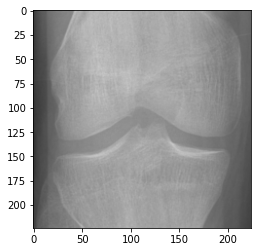

In [79]:
#QUESTION 4
from requests import get

def download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = get(url)
        # write to file
        file.write(response.content)

file_name = "/content/drive/MyDrive/kneeXray/test/0_9243046_1.png"

import cv2
img1 = cv2.imread(file_name)
rgb_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img1)

In [80]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [81]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.500, 0.500, 0.500],
                             [0.500, 0.500, 0.500])
        ])

img_t = transform(img1)
batch_t = torch.unsqueeze(img_t, 0).to(device)

out = model_ft(batch_t)
print(out.shape)

torch.Size([1, 5])


4 0.9848471283912659
3 0.015152806416153908
1 4.0644990151328386e-10
0 3.367130359255288e-12
2 2.2988639529313015e-13


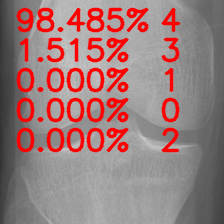

In [82]:
from google.colab.patches import cv2_imshow

classes = ['0', '1', '2', '3','4']

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities,5)

for i in range(top5_prob.size(0)):
    cv2.putText(img1, f"{top5_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img1, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())
    
cv2_imshow(img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

torch.Size([1, 5])
4 0.9585126042366028
3 0.04148731380701065
1 5.156763904778927e-08
0 1.1379310826953315e-09
2 1.5929375873913187e-10


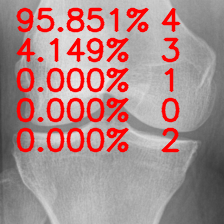

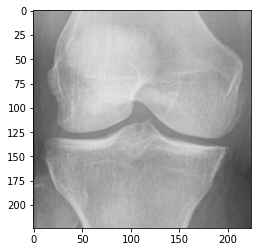

In [83]:
from requests import get

def download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = get(url)
        # write to file
        file.write(response.content)

file_name2 = "/content/drive/MyDrive/kneeXray/test/2_9487842_1.png"

import cv2
img2 = cv2.imread(file_name2)
rgb_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img2)

model_ft.eval()

transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.500, 0.500, 0.500],
                             [0.500, 0.500, 0.500])
        ])

img_t2 = transform(img2)
batch_t = torch.unsqueeze(img_t2, 0).to(device)

out = model_ft(batch_t)
print(out.shape)

from google.colab.patches import cv2_imshow

classes = ['0', '1', '2', '3','4']

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities,5)

for i in range(top5_prob.size(0)):
    cv2.putText(img2, f"{top5_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img2, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())
    
cv2_imshow(img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

torch.Size([1, 5])
4 0.9629791975021362
3 0.03702084347605705
1 1.4831908271006888e-11
2 2.360164743763632e-13
0 1.7617240403045714e-13


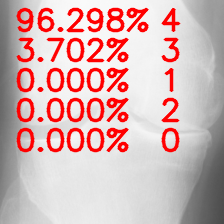

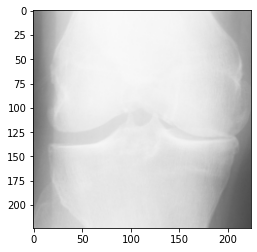

In [84]:
from requests import get

def download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = get(url)
        # write to file
        file.write(response.content)

file_name = "/content/drive/MyDrive/kneeXray/test/4_9390064_1.png"

import cv2
img3 = cv2.imread(file_name)
rgb_img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img3)

model_ft.eval()

transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.500, 0.500, 0.500],
                             [0.500, 0.500, 0.500])
        ])

img_t3 = transform(img3)
batch_t = torch.unsqueeze(img_t3, 0).to(device)

out = model_ft(batch_t)
print(out.shape)

from google.colab.patches import cv2_imshow

classes = ['0', '1', '2', '3','4']

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities,5)

for i in range(top5_prob.size(0)):
    cv2.putText(img3, f"{top5_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img3, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())
    
cv2_imshow(img3)
cv2.waitKey(0)
cv2.destroyAllWindows()